# Specific arrhythmia tests

In [149]:
from scipy.signal import argrelextrema
import invalid_sample_detection    as invalid
import load_annotations            as annotate
import regular_activity            as regular
import numpy                       as np
import matplotlib.pyplot           as plt
import parameters
import wfdb

data_path = 'sample_data/challenge_training_data/'
ann_path = 'sample_data/challenge_training_multiann/'
ecg_ann_type = 'gqrs'

## Asystole

In [18]:
def calc_channel_asystole_score(ann_path, sample_name, sig, fields, ann_type, channel_start, channel_end,
                                channel): 
    current_start = channel_start
    current_end = current_start + parameters.ASYSTOLE_WINDOW_SIZE
    cumulative_score = 0
    
    while current_end < channel_end: 
        channel_type = invalid.get_channel_type(channel)
        annotation, ann_fs = annotate.get_annotation_annfs(ann_path + sample_name, ann_type, current_start,
                                                           current_end, channel_type)
        
        if len(annotation[0]) > 0: 
            current_score = -1
        else: 
            current_score = 1
            
        invalids = invalid.calculate_invalids_sig(sig, fields, current_start, current_end)
        cval = invalid.calculate_cval(invalids)        
        current_score *= cval[channel]
        
        cumulative_score += current_score
        
        current_start += parameters.ASYSTOLE_ROLLING_INCREMENT
        current_end = current_start + parameters.ASYSTOLE_WINDOW_SIZE
    
    return cumulative_score   

In [21]:
def test_asystole(data_path, ann_path, sample_name, ecg_ann_type): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
        
    # Start and end given in seconds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    
    overall_score = 0    
    for channel_index, channel in zip(range(len(channels)), channels): 
        ann_type = annotate.get_ann_type(channel, channel_index, ecg_ann_type)
        channel_score = calc_channel_asystole_score(ann_path, sample_name, sig, fields, ann_type, start, end, 
                                                    channel)
        
        overall_score += channel_score
        
    return overall_score > 0
    
    
sample_name = "a203l" # true alarm
# sample_name = "a152s" # false alarm

print test_asystole(data_path, ann_path, sample_name, ecg_ann_type)

No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations in specified sample range
No annotations i

## Bradycardia

In [56]:
def get_rr_intervals_list(ann_path, sample_name, ecg_ann_type, fields, start, end): 
    channels = fields['signame']
    rr_intervals_list = []
    
    for channel_index in range(len(channels)): 
        rr_intervals = annotate.get_channel_rr_intervals(ann_path, sample_name, channel_index, fields,
                                                         ecg_ann_type, start, end)
        rr_intervals_list.append(rr_intervals)
        
    return rr_intervals_list


# Precondition: len(rr_intervals_list) > 0
# Return RR intervals with the min stdev of all the RR intervals in the list
def min_stdev_rr_intervals(rr_intervals_list): 
    opt_rr_intervals = []
    min_stdev = float('inf')
    
    for rr_intervals in rr_intervals_list: 
        stdev = np.std(rr_intervals)        
        if stdev < min_stdev: 
            opt_rr_intervals = rr_intervals
            min_stdev = stdev
    
    return opt_rr_intervals

In [57]:
# Best channel: minimum stdev with acceptable RR intervals sum and count
# If none with acceptable RR interval sum and count --> select minimum stdev out of all RR intervals
def find_best_channel(rr_intervals_list, alarm_duration): 
    count_and_sum = []
    only_one_test = []
    for rr_intervals in rr_intervals_list: 
        sum_check = regular.check_sum_rr_intervals(rr_intervals, alarm_duration)
        num_check = regular.check_num_rr_intervals(rr_intervals)
        
        if sum_check and num_check: 
            count_and_sum.append(rr_intervals)
        
        elif sum_check or num_check: 
            only_one_test.append(rr_intervals)
    
    if len(count_and_sum) > 0: 
        return min_stdev_rr_intervals(count_and_sum)
    
    if len(only_one_test) > 0: 
        return min_stdev_rr_intervals(only_one_test)
    
    return min_stdev_rr_intervals(rr_intervals_list)            

In [114]:
def get_average_hr_blocks(rr_intervals, num_beats_per_block): 
    hr_sum = 0.
    hr_num = 0
    
    for index in range(num_beats_per_block, len(rr_intervals)): 
        subsection = rr_intervals[index - num_beats_per_block:index]
        hr = float(num_beats_per_block) / sum(subsection) * parameters.NUM_SECS_IN_MIN
                
        hr_sum += hr
        hr_num += 1
        
    return hr_sum / hr_num    

In [208]:
def test_bradycardia(data_path, ann_path, sample_name, ecg_ann_type): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
            
    # Start and end given in seconds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    
    rr_intervals_list = get_rr_intervals_list(ann_path, sample_name, ecg_ann_type, fields, start, end)    
    best_channel_rr = find_best_channel(rr_intervals_list, alarm_duration)
    average_hr_blocks = get_average_hr_blocks(best_channel_rr, parameters.BRADYCARDIA_NUM_BEATS)
    print average_hr_blocks
    
    return average_hr_blocks < parameters.HR_MIN


sample_name = "b227l" # "b183l" # true alarm
# sample_name = "b216s" #"b184s" # false alarm

print test_bradycardia(data_path, ann_path, sample_name, ecg_ann_type)

48.8345809721
False


## Tachycardia

In [106]:
def check_tachycardia_channel(rr_intervals_list, alarm_duration): 
    for rr_intervals in rr_intervals_list: 
        stdev_check = regular.check_rr_stdev(rr_intervals)
        sum_check = regular.check_sum_rr_intervals(rr_intervals, alarm_duration)
        hr_check = regular.check_heart_rate(rr_intervals, alarm_duration)
        if stdev_check and sum_check and not hr_check:
                return True
            
    return False

In [116]:
def test_tachycardia(data_path, ann_path, sample_name, ecg_ann_type): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
        
    # Start and end given in s#econds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    
    rr_intervals_list = get_rr_intervals_list(ann_path, sample_name, ecg_ann_type, fields, start, end)    
    if check_tachycardia_channel(rr_intervals_list, alarm_duration): 
        return True    
    
    best_channel_rr = find_best_channel(rr_intervals_list, alarm_duration)
        
    average_hr_blocks = get_average_hr_blocks(best_channel_rr, parameters.TACHYCARDIA_NUM_BEATS)
    return get_average_hr_blocks(best_channel_rr, parameters.BRADYCARDIA_NUM_BEATS) > parameters.TACHYCARDIA_HR_MAX


# sample_name = "t209l" # true alarm
sample_name = "t384s" # false alarm
print test_tachycardia(data_path, ann_path, sample_name, ecg_ann_type)

[Errno 2] No such file or directory: 'sample_data/challenge_training_multiann/t384s.wpleth'
False


## Ventricular tachycardia

In [302]:
# Returns index of peak (max value) in the signal out of the indices provided
def get_peak_index(signal, peak_indices): 
    max_peak_value = 0
    max_peak_index = 0
    
    for index in peak_indices: 
        if signal[index] > max_peak_value: 
            max_peak_value = signal[index]
            max_peak_index = index
    
    return max_peak_index

# Groups together indices for a single peak and outputs a list of peaks (one sample per peak)
# param index_threshold: minimum difference in sample number to be classified as a different peak
def get_single_peak_indices(signal, peak_indices, index_threshold=50): 
    single_peak_indices = np.array([])
    current_peak_indices = []
    prev_index = peak_indices[0]
    
    for index in peak_indices[1:]: 
        if abs(prev_index - index) > index_threshold: 
            peak_index = get_peak_index(signal, current_peak_indices)
            single_peak_indices = np.append(single_peak_indices, peak_index)
            current_peak_indices = [index]
        else: 
            current_peak_indices.append(index)
        
        prev_index = index

    # Handle the last peak
    peak_index = get_peak_index(signal, current_peak_indices)
    single_peak_indices = np.append(single_peak_indices, peak_index)
    
    return single_peak_indices

/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:41: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


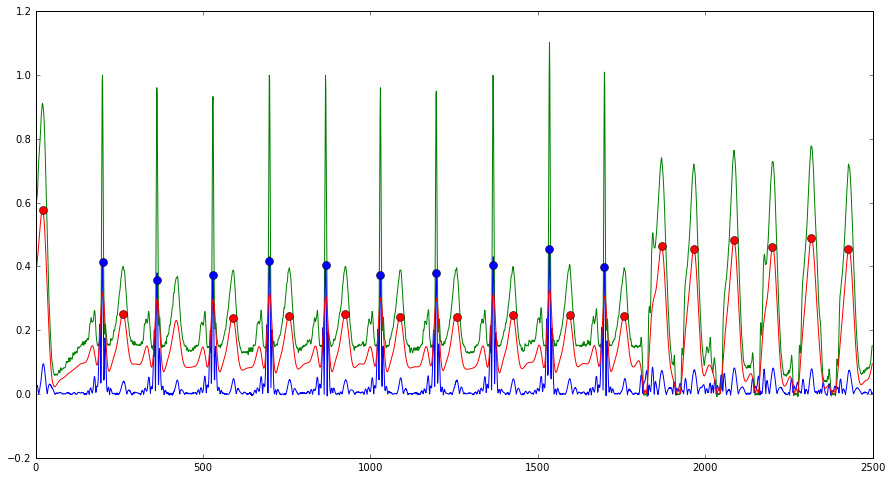

[   21.   261.   591.   758.   925.  1089.  1258.  1426.  1595.  1758.
  1870.  1966.  2086.  2201.  2317.  2428.]


In [304]:
def ventricular_beat_annotations(channel_sig, 
                                 order=parameters.ORDER, 
                                 threshold_ratio=parameters.VENTRICULAR_BEAT_THRESHOLD_RATIO,
                                 ventricular_beat_percentile=parameters.VENTRICULAR_BEAT_PERCENTILE):
    lf = abs(invalid.band_pass_filter(channel_sig, parameters.LF_LOW, parameters.LF_HIGH, order))
    mf = abs(invalid.band_pass_filter(channel_sig, parameters.MF_LOW, parameters.MF_HIGH, order))
    hf = abs(invalid.band_pass_filter(channel_sig, parameters.HF_LOW, parameters.HF_HIGH, order))
    sub = mf - hf
    
    base_threshold = np.percentile(channel_sig, ventricular_beat_percentile)
    threshold = threshold_ratio * base_threshold

    sig_peak_indices = np.array([ index for index in range(len(channel_sig)) if channel_sig[index] > threshold ])
    single_peak_indices = get_single_peak_indices(channel_sig, sig_peak_indices)
    sig_peaks = [ channel_sig[index] for index in single_peak_indices ]
    
    ventricular_beat_indices = np.array([])
    nonventricular_beat_indices = np.array([])
    for index in single_peak_indices: 
        if lf[index] > sub[index]: 
            ventricular_beat_indices = np.append(ventricular_beat_indices, index)
        else: 
            nonventricular_beat_indices = np.append(nonventricular_beat_indices, index)
       
    plt.figure(figsize=[15,8])
    plt.plot(channel_sig, 'g-')
    plt.plot(sub,'b-')
    plt.plot(lf,'r-')
    
    plt.plot(nonventricular_beat_indices, [sub[index] for index in nonventricular_beat_indices], 'bo', markersize=8)
    plt.plot(ventricular_beat_indices, [ lf[index] for index in ventricular_beat_indices ], 'ro', markersize=8)
    plt.show()
    
    return ventricular_beat_indices
    
start_time = 290
end_time = 300
start = start_time * parameters.DEFAULT_ECG_FS
end = end_time * parameters.DEFAULT_ECG_FS
sig, fields = wfdb.rdsamp(data_path + "v797l")
print ventricular_beat_annotations(sig[start:end,0])

In [298]:
def max_ventricular_hr(ventricular_beats, num_beats, fs): 
    max_hr = 0
            
    for index in range(num_beats, len(ventricular_beats)): 
        sublist = ventricular_beats[index-num_beats:index]
        start_time = sublist[0] / fs
        end_time = sublist[-1] / fs
                
        hr = num_beats / (end_time - start_time) * parameters.NUM_SECS_IN_MIN         
        max_hr = max(hr, max_hr)    
        
    return max_hr

/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:12: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:15: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:30: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
/home/liandrea/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:31: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


channel_name:  II


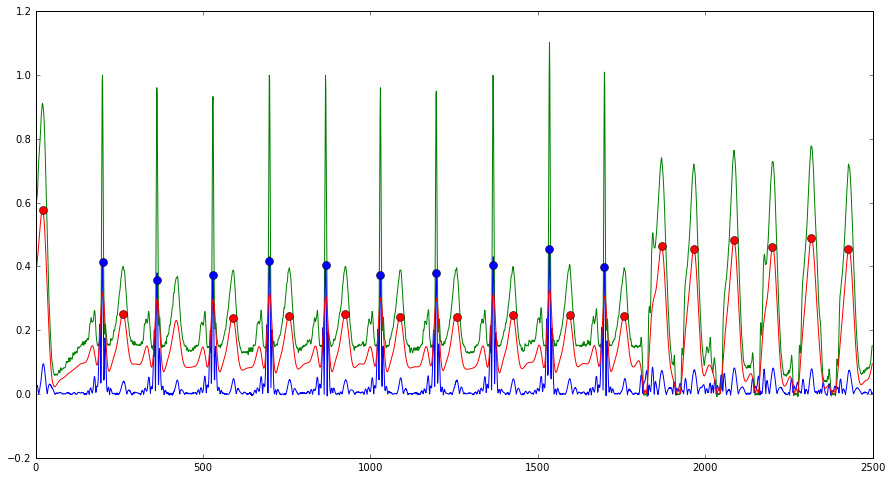

True


In [305]:
def test_ventricular_tachycardia(data_path, 
                                 sample_name, 
                                 fs=parameters.DEFAULT_ECG_FS,
                                 num_beats=parameters.VTACH_NUM_BEATS,
                                 max_hr=parameters.VTACH_MAX_HR): 
    sig, fields = wfdb.rdsamp(data_path + sample_name)
    channels = fields['signame']
        
    # Start and end given in seconds
    start, end, alarm_duration = invalid.get_start_and_end(fields)
    
    alarm_sig = sig[start*fs:end*fs,:]
    
    for channel_index in range(len(channels)): 
        channel_name = channels[channel_index]
        channel_type = invalid.get_channel_type(channel_name)
        channel_sig = alarm_sig[:,channel_index]
        
        print "channel_name: ", channel_name
        
        if channel_type == "ECG": 
            ventricular_beats = ventricular_beat_annotations(channel_sig)
            
            if len(ventricular_beats) < num_beats: 
                continue            
            if max_ventricular_hr(ventricular_beats, num_beats, fs) > max_hr: 
                return True
            
        elif channel_type == "ABP": 
            print np.std(channel_sig)
        
    return False
        
print test_ventricular_tachycardia(data_path, "v797l")